# Useing Pytorch Calculating Information Entropy after MNIST Prediction

## Loading Packages and Settings

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import sys
import time
import numpy as np

import torch
from torch import nn, optim
import torchvision
from torchkeras import summary

import matplotlib.pyplot as plt
import cv2

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("[DEVICE]", device)

[DEVICE] cuda


## Load MNIST Dataset

In [4]:
def load_data_mnist(batch_size, resize=None, root='~/Datasets'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())

    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.MNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_iter, test_iter

In [5]:
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size=batch_size)

In [6]:
img_rows, img_cols = 28, 28
num_classes = 10

## LeNet1

### Define the Model

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2), # in_channels, out_channels, kernel_size
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 7 * 7, num_classes),
            nn.Sigmoid()
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [8]:
net = LeNet()
summary(net, input_shape=(1, img_rows, img_cols))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           4,624
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Linear-7                   [-1, 10]           7,850
           Sigmoid-8                   [-1, 10]               0
Total params: 13,306
Trainable params: 13,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.002991
Forward/backward pass size (MB): 0.484650
Params size (MB): 0.050758
Estimated Total Size (MB): 0.538399
----------------------------------------------------------------


### Training the Model

In [9]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定 device 就使用 net 的 device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭 dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 不考虑 GPU
                if('is_training' in net.__code__.co_varnames): # 如果有 is_training 这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [10]:
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [11]:
lr, num_epochs = 0.001, 10
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.Adam(net.parameters())    # lr is not required
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 1.6784, train acc 0.816, test acc 0.917, time 1.9 sec
epoch 2, loss 1.5376, train acc 0.932, test acc 0.952, time 1.9 sec
epoch 3, loss 1.5107, train acc 0.956, test acc 0.966, time 1.8 sec
epoch 4, loss 1.4996, train acc 0.967, test acc 0.973, time 1.8 sec
epoch 5, loss 1.4938, train acc 0.972, test acc 0.976, time 1.8 sec
epoch 6, loss 1.4899, train acc 0.975, test acc 0.976, time 1.7 sec
epoch 7, loss 1.4869, train acc 0.978, test acc 0.980, time 1.7 sec
epoch 8, loss 1.4843, train acc 0.980, test acc 0.982, time 1.8 sec
epoch 9, loss 1.4832, train acc 0.981, test acc 0.981, time 1.7 sec
epoch 10, loss 1.4814, train acc 0.982, test acc 0.984, time 1.9 sec


### Model Evaluation

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in test_iter:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

print(
    "The accuracy in the test set of 10,000-pictures was: {:.2f}%".format(
        correct.cpu().numpy() / total * 100)
)

The accuracy in the test set of 10,000-pictures was: 98.36%


In [13]:
model_dir = os.path.join(os.path.abspath('.'), "models")
model_name = "lenet1.pth"

In [14]:
if not os.path.exists(model_dir):
    # If models directory does not exist, create a directory
    os.makedirs(model_dir) 
    print("[INFO]", model_dir, "is Successfully Created!")

torch.save(net.state_dict(), os.path.join(model_dir, model_name))
print("[INFO]", model_name, "Model File is Successfully Saved!")

[INFO] lenet1.pth Model File is Successfully Saved!


## Priority Score

### Reload the Model

In [15]:
pretrained_net = torch.load(os.path.join(model_dir, model_name))
load_net = LeNet()
load_net.load_state_dict(pretrained_net)
print("[INFO]", model_name, "Model File is Successfully Loaded!")
# del net

[INFO] lenet1.pth Model File is Successfully Loaded!


In [16]:
summary(load_net, input_shape=(1, img_rows, img_cols))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           4,624
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Linear-7                   [-1, 10]           7,850
           Sigmoid-8                   [-1, 10]               0
Total params: 13,306
Trainable params: 13,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.002991
Forward/backward pass size (MB): 0.484650
Params size (MB): 0.050758
Estimated Total Size (MB): 0.538399
----------------------------------------------------------------


### Calculate the Priority Score

In [17]:
classes = tuple(range(num_classes))

In [18]:
def xi_score(idx, model, n_class=10):
    
    dataiter = iter(test_iter)        # 把测试数据放在迭代器 iter
    images, labels = dataiter.next()
    images = images.to(device)
    labels = labels.to(device)
    
    plot_image = images[idx].cpu().numpy().reshape(img_rows, img_cols)
    x_input = images[idx].reshape(-1, 1, img_rows, img_cols).cpu()
    outputs = model(x_input)
    predict_list = model(x_input).cpu().detach().numpy()
    predict_label = np.argmax(predict_list, axis=-1)

    x_score = - np.inner(
        predict_list[0],
        np.divide(np.log(predict_list)[0], np.log(n_class))
    )

    return predict_list[0], predict_label, x_score, classes[labels[idx]], plot_image

### Define a Print Function

In [19]:
def dense_to_onehot(labels_dense, n_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_onehot = np.zeros((num_labels,num_classes))
    labels_onehot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_onehot

In [20]:
def xi_print(p_lst, p_class, r_class, score):

    col_name = ["Label", "Predict_Probability", "FCT"]
    col_len = [len(item) for item in col_name]
    total_len = sum(col_len) + 3 * len(col_len) - 1

    title = "Predict Table"

    print(title.center(len(title) + 2).center(total_len, "="))
    print('_' * total_len)
    print(
        "", col_name[0], 
        "|", col_name[1], 
        "|", col_name[2], ""
    )
    print(
        "", "-" * col_len[0], 
        "|", "-" * col_len[1], 
        "|", "-" * col_len[2], ""
    )

#     pred_one_hot = np_utils.to_categorical(p_class, num_classes)
    pred_one_hot = dense_to_onehot(p_class, num_classes)[0]

    for idx, item in zip(range(len(p_lst)), p_lst):
        print(
            "", str(idx).center(col_len[0]), "|", 
            "%.6e".rjust(col_len[1] - 8) % item, "|", 
            str("*" * int(pred_one_hot[idx])).center(col_len[2]), ""
        )

    print('=' * total_len)
    print(" Realistic Class :", r_class)
    print(" Predict Class   :", p_class[0])
    print(" Predict Validity:", p_class[0] == r_class)
    print(" Priority Score  :", score)
    print('_' * total_len)

    return True

## Example

In [21]:
# For example
index = np.random.choice(range(batch_size))
print("Index:", index)
p_list, p_label, x_score, r_label, _ = xi_score(index, load_net, num_classes)
output = xi_print(p_list, p_label, r_label, x_score)

Index: 152
========== Predict Table ==========
___________________________________
 Label | Predict_Probability | FCT 
 ----- | ------------------- | --- 
   0   |        1.431841e-08 |     
   1   |        1.677064e-21 |     
   2   |        1.967118e-14 |     
   3   |        8.241845e-19 |     
   4   |        7.055617e-13 |     
   5   |        1.000000e+00 |  *  
   6   |        9.484194e-14 |     
   7   |        2.738430e-12 |     
   8   |        6.247323e-07 |     
   9   |        5.573767e-11 |     
 Realistic Class : 5
 Predict Class   : 5
 Predict Validity: True
 Priority Score  : 3.9889583e-06
___________________________________



[Eg.001] Index.0176:


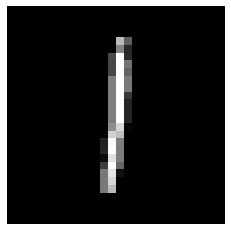

========== Predict Table ==========
___________________________________
 Label | Predict_Probability | FCT 
 ----- | ------------------- | --- 
   0   |        2.373806e-05 |     
   1   |        9.999980e-01 |  *  
   2   |        7.279323e-05 |     
   3   |        1.297069e-05 |     
   4   |        4.293202e-04 |     
   5   |        8.630037e-04 |     
   6   |        3.809989e-04 |     
   7   |        6.873820e-04 |     
   8   |        7.114615e-04 |     
   9   |        1.270086e-07 |     
 Realistic Class : 1
 Predict Class   : 1
 Predict Validity: True
 Priority Score  : 0.010282272
___________________________________

Quit for the Example? yes/[No]: y


In [22]:
key_in = ""
seed = 0
quit_input = ["y", "yes"]
while key_in.lower() not in quit_input:
    seed += 1
#     np.random.seed(seed)
    index = np.random.choice(range(batch_size))
    print(
        "\n[Eg." + str(seed).rjust(3, "0") + \
        "] Index." + str(index).rjust(4, "0") + ":"
    )
    
    p_list, p_label, x_score, r_label, plot_image = xi_score(index, load_net, num_classes)
    
    # Numerical Data Visualization
    im = plt.imshow(plot_image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    output = xi_print(p_list, p_label, r_label, x_score)

    if output:
        time.sleep(1)
        key_in = input("\nQuit for the Example? yes/[No]: ")
    else:
        break